In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
from training.train_depth import TrainerDepth
from training.eval_depth import DepthEval
from utils.data_loader import Dataset
from utils.utils import resize_image
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont

## Load dataset and networks

In [2]:
indoor_dataset = {'name':'diml-in',
                'path': '/scratch/s182169/DIML/indoor/test/prepared/',
                'params': {'focal': 512, 'baseline':74}} #74 

In [4]:
depth_eval = DepthEval([indoor_dataset],
                        ['./models/trained/disparity-in-out-full-nomaskimagenet.tar', './models/trained/disparity-refinement-in-out-full.tar'],
                      eval_refine=True,
                      perform_adjustment=False)
# depth_eval = DepthEval([indoor_dataset],
#                         ['./models/Pretrained_models/disparity-estimation.pytorch', './models/Pretrained_models/disparity-refinement.pytorch'],
#                       eval_refine=True, eval_pretrained = True)

{'name': 'diml-in', 'path': '/scratch/s182169/DIML/indoor/test/prepared/', 'params': {'focal': 512, 'baseline': 74}}
Loading models parameters...
Model disparity loaded succesfully.
Model refine loaded succesfully.


## Network evaluation

In [ ]:
depth_eval.eval()

### Utils function for visualization

In [5]:
def filter_masks(objectPredictions):
    boolUsed = {}
    tensorMasks = []
    
    for intMask in range(objectPredictions['masks'].size(0)):
        if intMask in boolUsed:
            continue

        elif objectPredictions['scores'][intMask].item() < 0.7:
            continue


        boolUsed[intMask] = True
        tensorMask = (objectPredictions['masks'][(intMask + 0):(intMask + 1), :, :, :] > 0.5).float()

        if tensorMask.sum().item() < 64:
            continue
        # end

        for intMerge in range(objectPredictions['masks'].size(0)):
            if intMerge in boolUsed:
                continue


            tensorMerge = (objectPredictions['masks'][(intMerge + 0):(intMerge + 1), :, :, :] > 0.5).float()

            if ((tensorMask + tensorMerge) > 1.0).sum().item() < 0.03 * tensorMerge.sum().item(): # if masks overlap too little (less than 3% do not merge masks)
                continue
            # end

            boolUsed[intMerge] = True
            tensorMask = (tensorMask + tensorMerge).clamp(0.0, 1.0)
        # end

        tensorMasks.append(tensorMask)
    print("{} masks used for adjustment".format(len(tensorMasks)))
    return tensorMasks

def get_masked_img(img, objectPredictions):
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    masks = filter_masks(objectPredictions)
    image = Image.fromarray(img, mode='RGB').convert('RGBA')
#     image.putalpha(128)
    overlay = Image.new('RGBA', image.size, (255,255,255,0))
    drawing = ImageDraw.Draw(overlay)
    for i in range(len(masks)):
        np_mask = np.round(masks[i][0,0].cpu().detach().numpy()) * 255
        np_mask = np_mask.astype(np.uint8)
        mask = Image.fromarray(np_mask, mode='L')
        drawing.bitmap((0, 0), mask, fill=(*np.random.randint(0,255,3), 128))
    
    image = Image.alpha_composite(image, overlay)
    return image

In [6]:
def plot_all(disp, disp_adjusted, disp_refined, truth, resized_truth, img, objects, masks, masks_resized):
    plt.figure(figsize=(70,20))
    n = disp.shape[0]
    for i in range(n):
        plt.subplot(n, 5, 5 * i + 1)
        plt.imshow(disp[i,0] * masks_resized[i, 0],  cmap='gray')
        plt.axis('off')
        plt.subplot(n, 5, 5 * i + 2)
        plt.imshow(disp_adjusted[i,0] * masks_resized[i, 0],  cmap='gray')
        plt.axis('off')
        plt.subplot(n, 5, 5 * i + 3)
        plt.imshow(disp_refined[i,0]* masks[i, 0],  cmap='gray')
        plt.axis('off')
        plt.subplot(n, 5, 5 * i + 4)
        plt.imshow(truth[i,0],  cmap='gray')
        plt.axis('off')
        plt.subplot(n, 5, 5 * i + 5)
        img_numpy = np.flip(img[i], axis=-1)*255
        img_numpy = img_numpy.astype(np.uint8)
        plt.imshow(get_masked_img(img_numpy, objects[i]))
        plt.axis('off')       

In [7]:
torch.manual_seed(456)
np.random.seed(123)
fig_idx = 0
fig_name = 'refine'
all_images = depth_eval.get_depths()

torch.Size([1, 3, 756, 1024])


1 masks used for adjustment


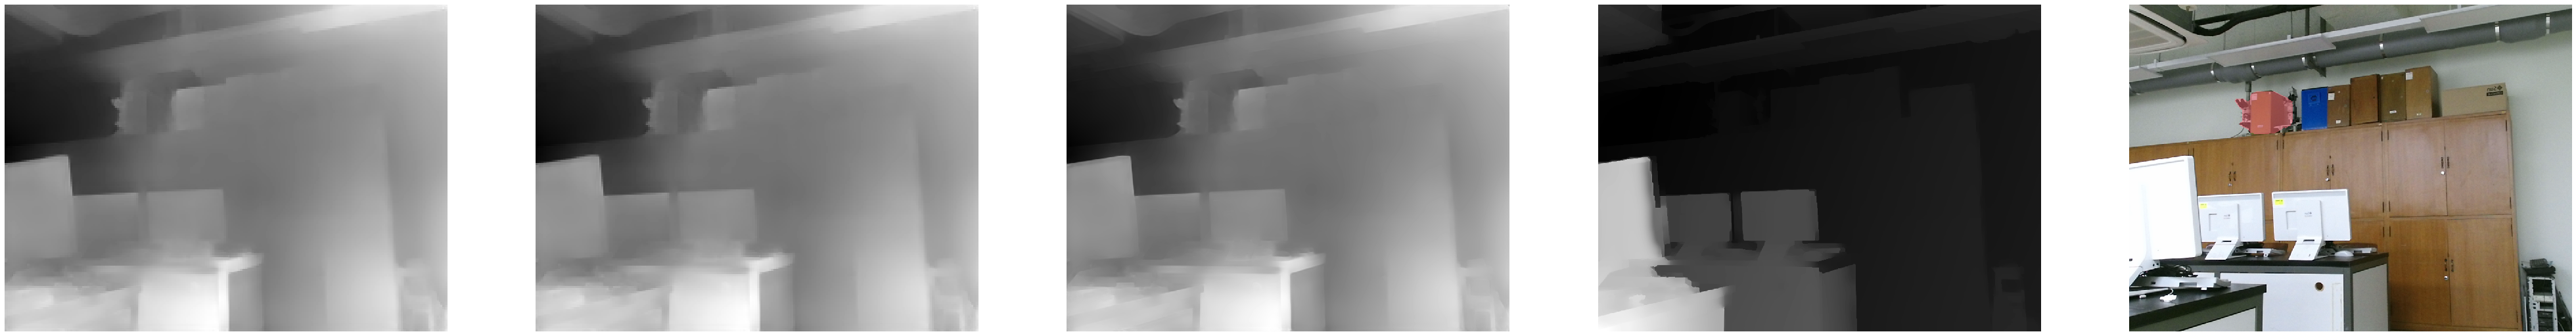

In [8]:
plot_all(*all_images)